CHECK VERSION AND DRIVERS

In [1]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it. This can be helpful for debugging.
!/usr/local/cuda/bin/nvcc --version
#take a look at the kind of GPU we have

!nvidia-smi
# Change the number depending on what GPU is listed above, under NVIDIA-SMI > Name.

# Tesla K80: 30
# Tesla P100: 60
# Tesla T4: 75
%env compute_capability=75

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Sun Feb  7 04:38:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+

#1. Set up the Custom Dataset



In [2]:
#if you already have YOLO darknet format, you can skip this step
#otherwise we recommend formatting in Roboflow
%cd /content
%mkdir dataset
%cd ./dataset
#!curl -L "[YOUR LINK HERE]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

#i got this link from roboflow
!curl -L "https://app.roboflow.com/ds/oGRFgT84nF?key=UOUhQDwh5b" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
/content/dataset
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   890  100   890    0     0    267      0  0:00:03  0:00:03 --:--:--   267
100 6765k  100 6765k    0     0  1944k      0  0:00:03  0:00:03 --:--:-- 1944k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/1--11-_jpg.rf.deee5d7f1e6759f63e62ea91d71a7fdf.jpg  
 extracting: test/1--11-_jpg.rf.deee5d7f1e6759f63e62ea91d71a7fdf.txt  
 extracting: test/1--26-_jpg.rf.58aa2261f7d30a5ae0626264e93c9387.jpg  
 extracting: test/1--26-_jpg.rf.58aa2261f7d30a5ae0626264e93c9387.txt  
 extracting: test/2--13-_jpg.rf.adb92230ebc96e99f170ffca073cf0da.jpg  
 extracting: test/2--13-_jpg.rf.adb92230ebc96e99f170ffca073cf0da.txt  
 extracting: test/2--23-_jpg.rf.dac6a3a7783399a3de31c63deaebdaed.jpg  
 extracting: test/2--23-_jpg.rf.dac6a3a7783399a3de31c63deaebdaed.txt  
 extractin

#2. Train a Custom Model on DarkNet

In [3]:
%cd /content/
%rm -rf darknet

#we clone the fork of darknet maintained by roboflow
#small changes have been made to configure darknet for training
!git clone https://github.com/roboflow-ai/darknet.git

#install environment from the Makefile. Changes to mitigate CUDA error.
%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_${compute_capability},code=sm_${compute_capability}/g" Makefile
!make

#download the newly released yolov4-tiny weights
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29


/content
Cloning into 'darknet'...
remote: Enumerating objects: 13289, done.
remote: Total 13289 (delta 0), reused 0 (delta 0), pack-reused 13289
Receiving objects: 100% (13289/13289), 12.13 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (9106/9106), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void

## Configure from Custom Dataset

In [4]:
#Copy dataset
%cp -r /content/dataset/. /content/darknet/
#Set up training file directories for custom dataset
%cd /content/darknet/
%cp train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp train/*.jpg data/obj/
%cp valid/*.jpg data/obj/

%cp train/*.txt data/obj/
%cp valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 3\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir('train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir('valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')


#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_darknet.labels')
max_batches = num_classes*333
steps1 = .8 * max_batches
steps2 = .9 * max_batches
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3


print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')


#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))


/content/darknet
writing config for a custom YOLOv4 detector detecting number of classes: 3


## Write Custom Training Config for YOLOv4

In [5]:
%%writetemplate ./cfg/custom-yolov4-tiny-detector.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = {max_batches}
policy=steps
steps={steps_str}
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

## Train Custom YOLOv4 Detector

In [6]:
!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg yolov4-tiny.conv.29 -dont_show -map
#If you get CUDA out of memory adjust subdivisions above!
#adjust max batches down for shorter training above

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
 compute_capability = 750, cudnn_half = 0 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
 

## Infer Custom Objects with Saved YOLOv4 Weights

In [7]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [8]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations

custom-yolov4-tiny-detector_best.weights
custom-yolov4-tiny-detector_final.weights
custom-yolov4-tiny-detector_last.weights


In [9]:
#save final weights to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Darknet Weights
!cp /content/darknet/backup/custom-yolov4-tiny-detector_final.weights "/content/drive/My Drive"
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 compute_capability = 750, cudnn_half = 0 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 max                2x 2/ 2    104 x 104 x 128 -

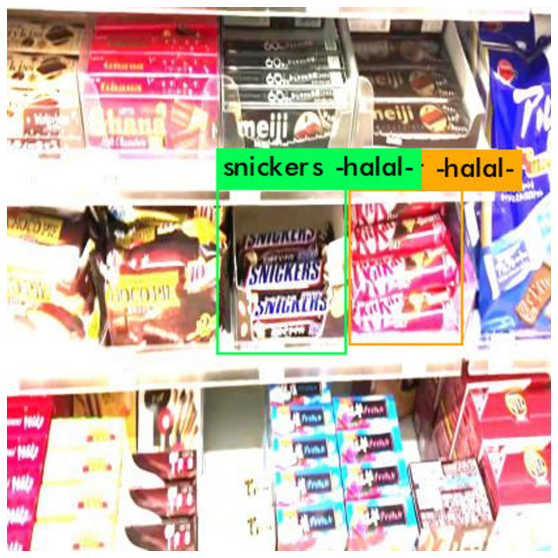

In [11]:
#/test has images that we can test our detector on
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

#test out our detector!
!./darknet detect cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_best.weights {img_path} -dont-show
imShow('predictions.jpg')

#3. Convert the weights to TensorFlow's .pb representation

## Install and Configure

In [12]:
%cd /content
!git clone https://github.com/hunglc007/tensorflow-yolov4-tflite.git
%cd /content/tensorflow-yolov4-tflite

!cp /content/darknet/data/obj.names /content/tensorflow-yolov4-tflite/data/classes/
!ls /content/tensorflow-yolov4-tflite/data/classes/

!sed -i "s/coco.names/obj.names/g" /content/tensorflow-yolov4-tflite/core/config.py

/content
Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 780, done.
remote: Total 780 (delta 0), reused 0 (delta 0), pack-reused 780
Receiving objects: 100% (780/780), 197.64 MiB | 31.95 MiB/s, done.
Resolving deltas: 100% (371/371), done.
/content/tensorflow-yolov4-tflite
coco.names  obj.names  voc.names  yymnist.names


## Convert

In [2]:
!pip install tensorflow==2.3.0

In [1]:
%cd /content/tensorflow-yolov4-tflite
# Regular TensorFlow SavedModel
!python save_model.py \
  --weights /content/darknet/backup/custom-yolov4-tiny-detector_final.weights \
  --output ./checkpoints/yolov4-tiny-416 \
  --input_size 416 \
  --model yolov4 \
  --tiny \

# SavedModel to convert to TFLite
!python save_model.py \
  --weights /content/darknet/backup/custom-yolov4-tiny-detector_final.weights \
  --output ./checkpoints/yolov4-tiny-pretflite-416 \
  --input_size 416 \
  --model yolov4 \
  --tiny \
  --framework tflite

/content/tensorflow-yolov4-tflite
2021-02-07 05:03:43.983507: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-02-07 05:03:45.242723: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-02-07 05:03:45.274510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-07 05:03:45.275094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-07 05:03:45.275127: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-02-07 05:03:45.276644: I tensorflo

#4. Convert the TensorFlow weights to TensorFlow Lite

From the generated TensorFlow SavedModel, we will convert to .tflite

In [2]:
%cd /content/tensorflow-yolov4-tflite
!python convert_tflite.py --weights ./checkpoints/yolov4-tiny-pretflite-416 --output ./checkpoints/yolov4-tiny-416.tflite

/content/tensorflow-yolov4-tflite
2021-02-07 05:04:14.079035: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-02-07 05:04:15.365028: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-02-07 05:04:15.402298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-07 05:04:15.402889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-07 05:04:15.402925: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-02-07 05:04:15.404465: I tensorflo

# Save your Model

You can save your model to your Google Drive for further use.

In [13]:
# Choose what to copy and saved to local
!cp -r /content/tensorflow-yolov4-tflite/checkpoints/yolov4-tiny-416.tflite /content

def download(path):
  from google.colab import files
  files.download(path)

download("/content/yolov4-tiny-416.tflite")


## saved to gdrive
# TensorFlow SavedModel
!cp -r /content/tensorflow-yolov4-tflite/checkpoints/yolov4-tiny-416/ "/content/drive/My Drive"
# TensorFlow Lite
!cp /content/tensorflow-yolov4-tflite/checkpoints/yolov4-tiny-416.tflite "/content/drive/My Drive"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>